# Face Identification

Testing: **batch size** on fine-tuning  
Output vector: **16** x float32  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 20:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/faceid-preprocessed-small/youtube_faces_with_keypoints_full.csv
/kaggle/input/faceid-preprocessed-small/Kevin_Spacey_5.npz.pkl
/kaggle/input/faceid-preprocessed-small/Lauren_Hutton_0.npz.pkl
/kaggle/input/faceid-preprocessed-small/Lauren_Hutton_1.npz.pkl
/kaggle/input/faceid-preprocessed-small/Lauren_Hutton_2.npz.pkl
/kaggle/input/faceid-preprocessed-small/Lauren_Hutton_3.npz.pkl
/kaggle/input/faceid-preprocessed-small/Lauren_Hutton_4.npz.pkl
/kaggle

In [2]:
!df /kaggle/

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        104802308 23344008  81458300  23% /


In [3]:
#!mkdir -pv /kaggle/temp
#!rm -Rf /kaggle/temp/*
#!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
#!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
#!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

In [4]:
#data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
data_dir = '/kaggle/input/faceid-preprocessed-small'

In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l ~/.cache/torch/hub/checkpoints/

mkdir: created directory '/root/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth' -> '/root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth'
'/kaggle/input/torc

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
5,Alison_Lohman_5,Alison_Lohman,227.0,179.0,68.0,105.647059,6.0
6,Kevin_Spacey_0,Kevin_Spacey,196.0,264.0,91.0,99.912088,6.0
7,Kevin_Spacey_1,Kevin_Spacey,260.0,217.0,59.0,120.186441,6.0
8,Kevin_Spacey_2,Kevin_Spacey,186.0,175.0,71.0,86.746479,6.0
9,Kevin_Spacey_3,Kevin_Spacey,100.0,89.0,99.0,44.636364,6.0


In [8]:
import poptorch
poptorch.ipuHardwareIsAvailable(num_ipus=1), poptorch.ipuHardwareIsAvailable(num_ipus=16), poptorch.ipuHardwareIsAvailable(num_ipus=32)

(True, True, False)

In [9]:
!mkdir -p /tmp/work/popcache
popcache_dir = '/tmp/work/popcache'
hw_emulation = False
#ipu_id = 16 # x2
#ipu_id = 24 # x4
#ipu_id = 28 # x8
ipu_id = 30 # x16

In [10]:
import torch
import torch.nn as nn
#import torch.optim as optim
import poptorch.optim as optim
import torchvision
from torchinfo import summary

In [11]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [12]:
import random
import pickle

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        need_preprocessing = []
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    need_preprocessing += [fp]
        if preprocess:
            preprocessed = [self._preprocess(fp) for fp in tqdm(need_preprocessing, desc='Preprocessing')]
            self.preprocessed_cache = dict((fp, self._load_preprocessed(pfp)) for fp, pfp in tqdm(preprocessed, desc='Loading data'))
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return (fp, pfp)
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir)
len(dataset)

Loading data: 100%|██████████| 4/4 [00:00<00:00, 902.53it/s]


4

In [13]:
to_pil_transform = torchvision.transforms.ToPILImage()
#to_pil_transform(dataset[0][1])

In [14]:
class PoptorchModel(nn.Module):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss

    def forward(self, xa, xp, xn):
        ya = self.model(xa)
        yp = self.model(xp)
        yn = self.model(xn)
        loss_data = self.loss(ya, yp, yn)
        return poptorch.identity_loss(loss_data, reduction='none')

def train_triplet_gc(model, dataset, num_epochs,
                     lr=0.001, batch_size=16, target_loss = 0,
                     gradient_accumulation=1, replication_factor=1):
    model.train()
    
    opts = poptorch.Options()
    if hw_emulation:
        opts.useIpuModel(True)
    opts.enableExecutableCaching(popcache_dir)
    opts.connectionType(poptorch.ConnectionType.OnDemand)
    opts.useIpuId(ipu_id)
    opts.Training.gradientAccumulation(gradient_accumulation)
    opts.replicationFactor(replication_factor)
    
    loss = torch.nn.TripletMarginLoss()
    loss_history = []
    print(f'lr: {lr}')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    poptorch_model = poptorch.trainingModel(PoptorchModel(model, loss), options=opts, optimizer=optimizer)
    data_loader = poptorch.DataLoader(opts, dataset, batch_size=batch_size)
    
    # run a batch to trigger compilation
    for xa, xp, xn in data_loader:
        poptorch_model(xa, xp, xn)
        break

    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            loss_data = poptorch_model(xa, xp, xn)

            loss_accum += float(loss_data.mean())
            loss_cnt += 1
    
        loss_value = loss_accum / loss_cnt
        print(f'loss: {loss_value}')

        if loss_history and loss_value > loss_history[-1]:
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
            poptorch_model.setOptimizer(optimizer)

        loss_history.append(loss_value)
        
        if loss_value <= target_loss:
            print(f'target loss {target_loss} reached')
            break

    poptorch_model.detachFromDevice()
    return loss_history

In [15]:
def create_faceid_model():
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 16)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [16]:
dataset = YouTubeFacesDataset(df, data_dir, anchor_set_len=20, positive_set_len=20, negative_set_len=20, preprocess=True)
len(dataset)

Loading data: 100%|██████████| 20/20 [00:00<00:00, 56.38it/s]


32000

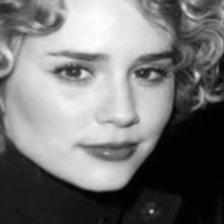

In [17]:
to_pil_transform(dataset[0][1])

---

In [18]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    skip = False
    loss_history = train_triplet_gc(model, dataset, 1, batch_size=4, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


train 1/1: 100%|██████████| 500/500 [03:02<00:00,  2.74it/s]


loss: 0.03383802311122418


In [19]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=8, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation: 100%|██████████| 100/100 [27:42<00:00]


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 2944: 722288 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace



In [20]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=16, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation: 100%|██████████| 100/100 [32:59<00:00]


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 0: 811900 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace
  [4] popart::popx::Devicex::prepare()
  [5] popart::Session::prepareDevice(bool)
  [6] poptorch::Compiler::compileAndPrepareDevice()
  [7] poptorch::detail::LowerToPopartImpl::compile()
  [8] poptorch::LowerToPopart::compile()



In [21]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=32, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation: 100%|██████████| 100/100 [50:22<00:00] 


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 0: 1491772 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace
  [4] popart::popx::Devicex::prepare()
  [5] popart::Session::prepareDevice(bool)
  [6] poptorch::Compiler::compileAndPrepareDevice()
  [7] poptorch::detail::LowerToPopartImpl::compile()
  [8] poptorch::LowerToPopart::compile()



In [ ]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=64, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation:  60%|██████    | 60/100 [1:00:05<24:43]

In [ ]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=128, gradient_accumulation=8, replication_factor=2)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

---

In [18]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    skip = False
    loss_history = train_triplet_gc(model, dataset, 1, batch_size=8, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


train 1/1: 100%|██████████| 250/250 [04:30<00:00,  1.08s/it]


loss: 0.019110482096672057


In [19]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=16, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation: 100%|██████████| 100/100 [44:51<00:00] 

Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 6526: 639888 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace



In [24]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=32, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation: 100%|██████████| 100/100 [1:05:21<00:00]


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 0: 997036 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace



In [ ]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=64, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

lr: 0.001


Graph compilation:   4%|▍         | 4/100 [05:16<1:55:01]

```
top - 17:27:47 up 6 days, 11 min,  0 users,  load average: 2.54, 41.31, 49.41
Tasks:   7 total,   2 running,   5 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.5 us,  0.0 sy,  0.0 ni, 99.5 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
MiB Mem : 483686.4 total, 119672.3 free, 335933.8 used,  28080.3 buff/cache
MiB Swap:      0.0 total,      0.0 free,      0.0 used. 262504.0 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND
  27764 root      20   0  432.6g 321.5g 294200 R 100.4  68.1   1190:03 python3
      8 root      20   0  350008  98420  19296 S   0.1   0.0   0:36.39 jupyter-lab
      1 root      20   0    2608    600    528 S   0.0   0.0   0:00.03 sh
    877 root      20   0    4468   3664   3140 S   0.0   0.0   0:00.08 bash
    929 root      20   0    6396   3536   2904 R   0.0   0.0   0:07.96 top
    930 root      20   0    4468   3684   3096 S   0.0   0.0   0:03.69 bash
  43712 root      20   0    2736    520    452 S   0.0   0.0   0:00.00 sleep
```

In [ ]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=128, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True

In [ ]:
model = create_faceid_model()
model = grayscale_fix_model(model)
model.requires_grad_(True)
try:
    if not skip:
        loss_history = train_triplet_gc(model, dataset, 1, batch_size=256, gradient_accumulation=16)
except Exception as e:
    print(f'Exception: {e}')
    #skip = True